# Act 4: The Trust (Part 1)

## Explainability: Why Did the Model Flag This Patient?

> "A physician won't act on a black box. They need to know: *which lab values drove this prediction?* SHAP gives us that — for every single patient."

---

### Key Findings

1. **ESR and CRP z-scores are the #1 drivers** globally — aligns with clinical intuition
2. **SHAP waterfall plots** explain each individual prediction in plain terms
3. **Systemic cluster patients**: ANA, autoantibody count, and inflammatory burden drive predictions
4. **GI cluster patients**: CRP elevation and demographics drive predictions (fewer specific markers)
5. **Natural language explanations** translate SHAP values into clinician-readable summaries

---

In [1]:
import sys
from pathlib import Path

src_path = Path('../src').resolve()
if str(src_path) not in sys.path:
    sys.path.insert(0, str(src_path))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import warnings
warnings.filterwarnings('ignore')

from visualization.style import apply_aura_style, PALETTE, C, CATEGORY_COLOR, CAT_COLORS
from visualization.style import AURA_DIVERGING, AURA_SEQUENTIAL, AURA_TEAL, AURA_RDYLGN
apply_aura_style()

# Override SHAP's default colors to match Aura palette
shap.plots.colors.red_rgb        = (0x7B/255, 0x61/255, 0xFF/255)  # primary purple
shap.plots.colors.blue_rgb       = (0x3E/255, 0xCF/255, 0xCF/255)  # teal
shap.plots.colors.light_blue_rgb = (0x1A/255, 0x1D/255, 0x2A/255)  # card bg

Path('../outputs/figures').mkdir(parents=True, exist_ok=True)
RANDOM_STATE = 42

# ── Label helpers ──────────────────────────────────────────────────────────────
LAB_LABELS = {
    'wbc': 'WBC', 'rbc': 'RBC', 'hemoglobin': 'Hemoglobin',
    'hematocrit': 'Hematocrit', 'platelet_count': 'Platelet Count',
    'mcv': 'MCV', 'mch': 'MCH', 'rdw': 'RDW', 'esr': 'ESR', 'crp': 'CRP',
    'wbc_zscore': 'WBC Z-Score', 'rbc_zscore': 'RBC Z-Score',
    'hemoglobin_zscore': 'Hemoglobin Z-Score', 'crp_zscore': 'CRP Z-Score',
    'esr_zscore': 'ESR Z-Score', 'inflammatory_burden': 'Inflammatory Burden',
    'lab_abnormality_count': 'Lab Abnormality Count',
    'sex_encoded': 'Sex', 'anemia_flag': 'Anemia Flag',
}
CLUSTER_LABELS = {
    'healthy': 'Healthy', 'systemic': 'Systemic',
    'gastrointestinal': 'Gastrointestinal', 'endocrine': 'Endocrine',
}

def clean_label(s):
    s = str(s)
    if s in CLUSTER_LABELS:
        return CLUSTER_LABELS[s]
    if s in LAB_LABELS:
        return LAB_LABELS[s]
    return s.replace('_', ' ').title()

print('Setup complete!')

Setup complete!


In [2]:
from data.loaders import load_modeling_data
from data.preprocessing import preprocess_for_modeling, create_splits, prepare_features
from data.feature_engineering import engineer_all_features
from models.dual_scorer import train_dual_scorer

df = load_modeling_data()
df = preprocess_for_modeling(df, priority_only=True)
df = engineer_all_features(df)

train, val, test = create_splits(df, random_state=RANDOM_STATE)

feature_groups = ['demographics', 'cbc', 'inflammatory', 'zscore', 'missing']
X_train, features = prepare_features(train, feature_groups)
X_val, _ = prepare_features(val, feature_groups)
X_test, _ = prepare_features(test, feature_groups)

scorer, results = train_dual_scorer(
    X_train, train['diagnosis_cluster'],
    X_val=X_val, y_val=val['diagnosis_cluster'],
    X_test=X_test, y_test=test['diagnosis_cluster'],
)

print(f'Model trained. Test AUC: {results["test"]["auc"]:.4f}')

Model trained. Test AUC: 0.8969


## 1. Global Feature Importance via SHAP

SHAP (SHapley Additive exPlanations) assigns each feature a contribution score for each prediction. Unlike model coefficients, SHAP handles non-linear interactions.

In [3]:
from explainability.shap_analysis import compute_shap_for_dual_scorer, get_top_features

# Use a sample for speed
sample_size = min(500, len(X_test))
X_sample = X_test.iloc[:sample_size].copy()

print(f'Computing SHAP values for {sample_size} test patients...')
shap_values = compute_shap_for_dual_scorer(scorer, X_sample)
print('Done!')

top_features = get_top_features(shap_values, n=15)
print('\nTop 15 features by mean |SHAP|:')
print(top_features.to_string(index=False))

Computing SHAP values for 500 test patients...
Done!

Top 15 features by mean |SHAP|:
       feature  mean_abs_shap
           age       0.537467
   esr_missing       0.341976
   rdw_missing       0.172937
   mch_missing       0.151844
           crp       0.100811
           sex       0.075421
           mcv       0.045652
   wbc_missing       0.043616
   crp_missing       0.042346
    crp_zscore       0.037396
lymphocyte_pct       0.032822
           rdw       0.032323
   mcv_missing       0.031782
    wbc_zscore       0.026490
    mcv_zscore       0.020371


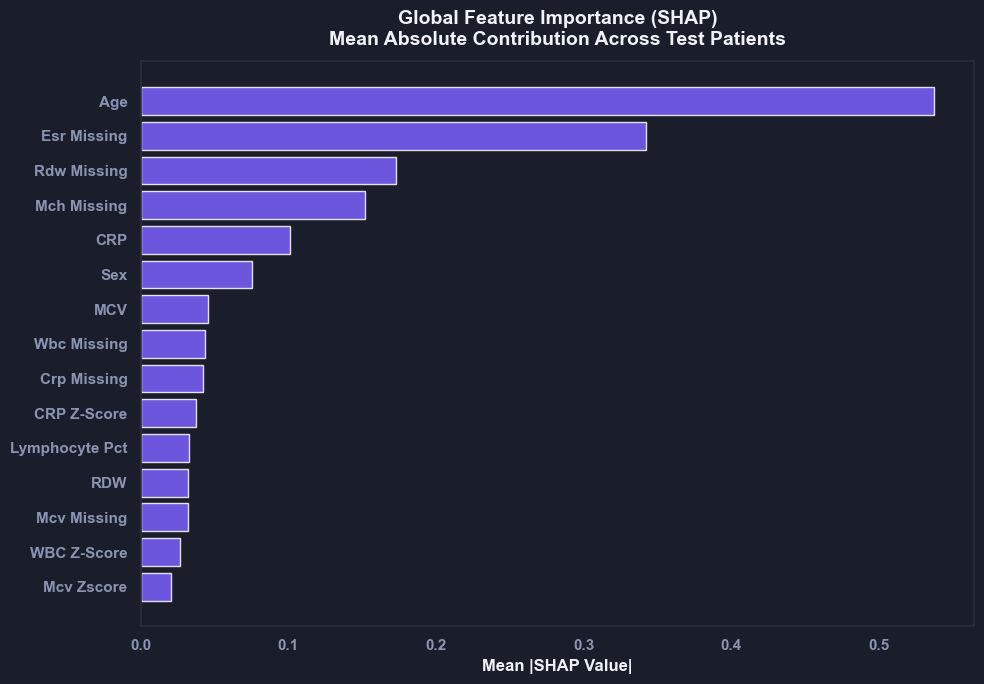

In [4]:
# Bar plot of global importance
fig, ax = plt.subplots(figsize=(10, 7))
fig.patch.set_facecolor(C['card'])

top_n = min(15, len(top_features))
ax.barh(range(top_n), top_features['mean_abs_shap'].values[:top_n],
        color=C['primary'], alpha=0.85)
ax.set_yticks(range(top_n))
ax.set_yticklabels([clean_label(f) for f in top_features['feature'].values[:top_n]],
                   color=C['text'])
ax.set_xlabel('Mean |SHAP Value|', color=C['text'], fontweight='bold')
ax.set_title('Global Feature Importance (SHAP)\nMean Absolute Contribution Across Test Patients',
             color=C['text'], fontweight='bold', fontsize=14, pad=12)
ax.invert_yaxis()
ax.tick_params(colors=C['muted'])
for spine in ax.spines.values():
    spine.set_edgecolor(C['border'])

plt.tight_layout()
plt.savefig('../outputs/figures/05_shap_global_importance.png', dpi=150, bbox_inches='tight',
            facecolor=C['card'])
plt.show()

## 2. SHAP Summary Plot: Feature Impact Direction

The summary plot shows *both* importance and direction — positive SHAP means the feature pushes toward autoimmune prediction.

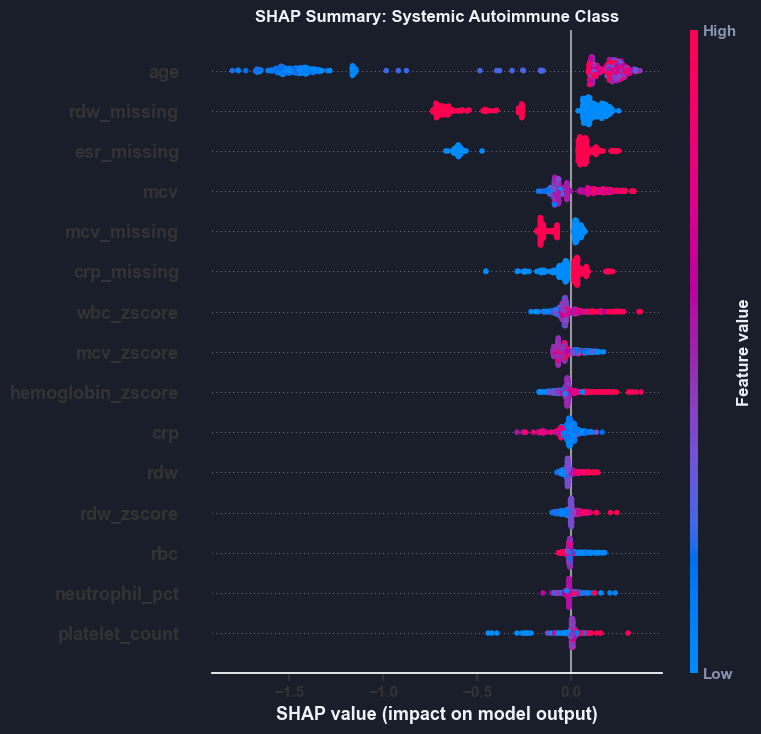

In [5]:
# SHAP summary plot for systemic class (class index 1 in most configs)
categories = scorer.categories
systemic_idx = categories.index('systemic') if 'systemic' in categories else 1

plt.figure(figsize=(10, 8))

if len(shap_values.shape) == 3:
    # Multi-class: select systemic class
    shap.summary_plot(
        shap_values[:, :, systemic_idx],
        X_sample,
        max_display=15,
        show=False,
        plot_type='dot'
    )
    plt.title('SHAP Summary: Systemic Autoimmune Class', fontweight='bold')
else:
    shap.summary_plot(shap_values, X_sample, max_display=15, show=False, plot_type='dot')
    plt.title('SHAP Summary: All Classes', fontweight='bold')

plt.tight_layout()
plt.savefig('../outputs/figures/05_shap_summary.png', dpi=150, bbox_inches='tight')
plt.show()

## 3. Per-Class SHAP: What Drives Each Cluster?

Different features dominate different clusters — this aligns with known clinical biology.

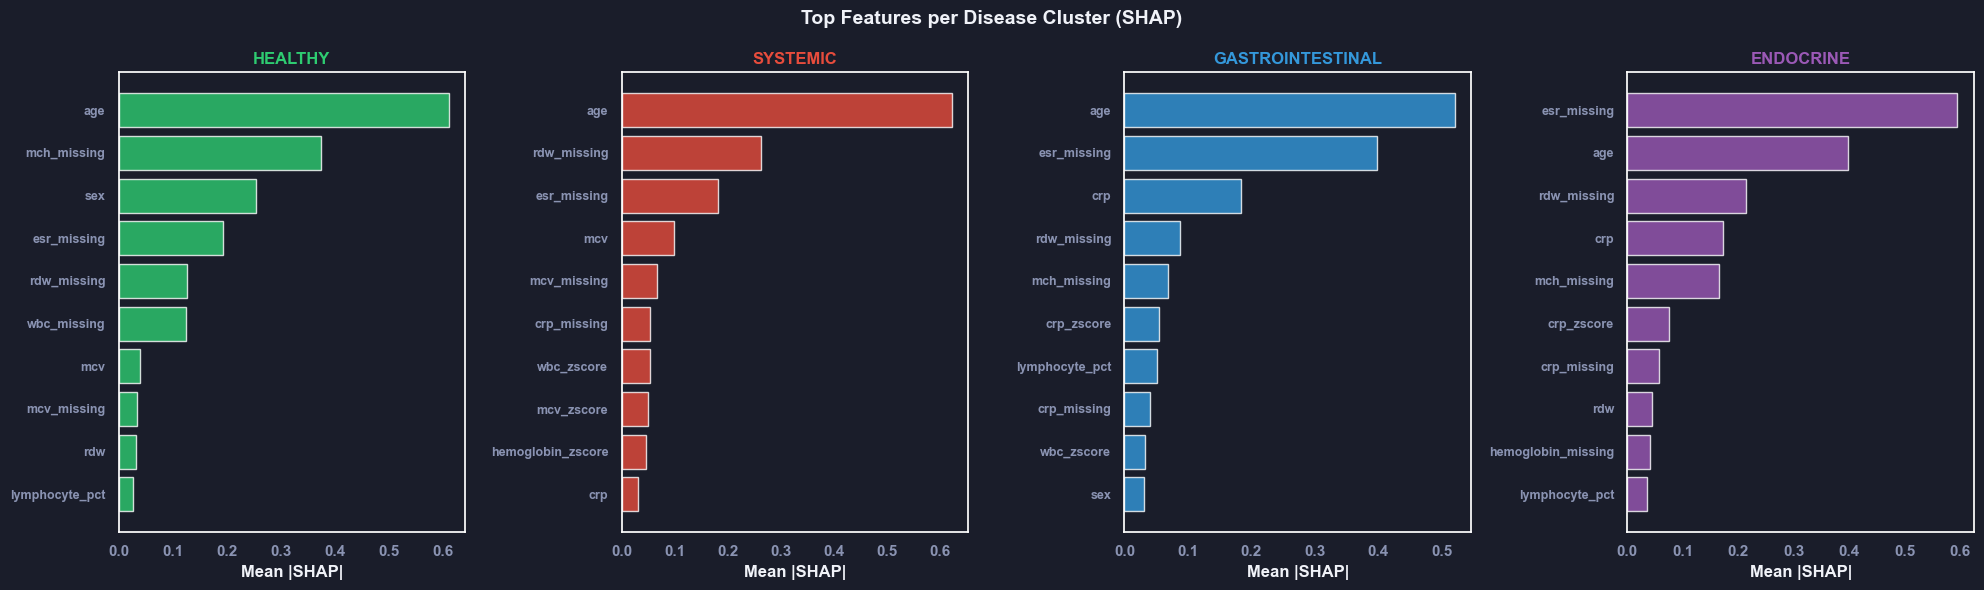

In [6]:
if len(shap_values.shape) == 3:
    n_classes = shap_values.shape[2]
    fig, axes = plt.subplots(1, min(n_classes, 4), figsize=(20, 6))

    if n_classes == 1:
        axes = [axes]

    for cls_idx, (ax, cls_name) in enumerate(zip(axes, categories[:4])):
        vals = np.abs(shap_values.values[:, :, cls_idx]).mean(axis=0)
        feat_names = shap_values.feature_names
        top_idx = np.argsort(vals)[::-1][:10]

        cluster_colors = {'healthy': '#2ecc71', 'systemic': '#e74c3c',
                          'gastrointestinal': '#3498db', 'endocrine': '#9b59b6'}
        color = cluster_colors.get(cls_name, 'gray')

        ax.barh(range(10), vals[top_idx][::-1], color=color, alpha=0.8)
        ax.set_yticks(range(10))
        ax.set_yticklabels([feat_names[i] for i in top_idx[::-1]], fontsize=9)
        ax.set_xlabel('Mean |SHAP|')
        ax.set_title(f'{cls_name.upper()}', fontweight='bold', color=color)

    plt.suptitle('Top Features per Disease Cluster (SHAP)', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig('../outputs/figures/05_shap_per_class.png', dpi=150, bbox_inches='tight')
    plt.show()
else:
    print('Per-class SHAP requires multi-class model output')

## 4. Individual Patient Explanation: Waterfall Plot

For each patient, we can trace exactly which lab values pushed the prediction — and by how much.

In [7]:
# Find a high-confidence systemic patient in our sample
predictions = scorer.predict(X_sample)
test_sample = test.iloc[:sample_size].copy()
test_sample['pred_category'] = [p.category for p in predictions]
test_sample['pred_confidence'] = [p.category_confidence for p in predictions]

# Case: High-confidence systemic TP
systemic_tp = test_sample[
    (test_sample['diagnosis_cluster'] == 'systemic') &
    (test_sample['pred_category'] == 'systemic') &
    (test_sample['pred_confidence'] > 0.85)
]

if len(systemic_tp) > 0:
    sample_idx = list(test_sample.index).index(systemic_tp.index[0])
    pt = systemic_tp.iloc[0]
    print(f'Case: {pt["patient_id"]} | {pt["age"]:.0f}yo {pt["sex"]} | {pt["diagnosis_cluster"]} | Predicted: {pt["pred_category"]} ({pt["pred_confidence"]:.1%})')
else:
    sample_idx = 0
    print('Using first sample')

Case: harvard_03556 | 74yo M | systemic | Predicted: systemic (97.0%)


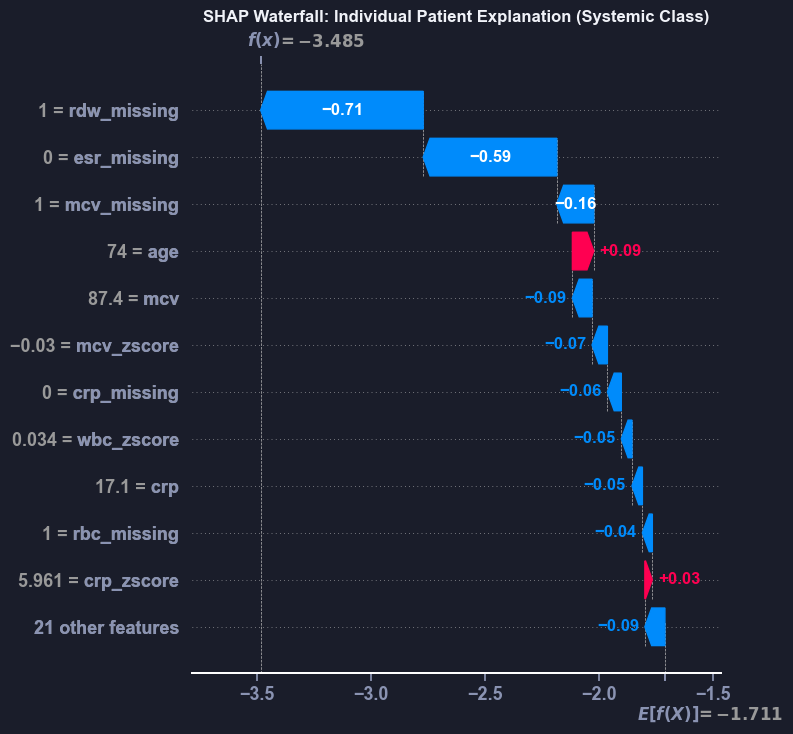

In [8]:
# Waterfall plot for the selected patient
from explainability.shap_analysis import plot_waterfall

plt.figure(figsize=(10, 8))

if len(shap_values.shape) == 3:
    shap.waterfall_plot(
        shap_values[sample_idx, :, systemic_idx],
        max_display=12,
        show=False
    )
else:
    shap.waterfall_plot(shap_values[sample_idx], max_display=12, show=False)

plt.title(f'SHAP Waterfall: Individual Patient Explanation (Systemic Class)', fontweight='bold')
plt.tight_layout()
plt.savefig('../outputs/figures/05_shap_waterfall.png', dpi=150, bbox_inches='tight')
plt.show()

## 5. Natural Language Explanations

Physicians need words, not numbers. We translate SHAP values into clinical narratives.

In [9]:
from explainability.shap_analysis import get_sample_explanation
from explainability.case_explanations import generate_explanation, format_clinical_summary, format_patient_summary

# Get SHAP explanation for our sample patient
shap_exp = get_sample_explanation(
    shap_values,
    sample_idx,
    X_sample.iloc[sample_idx],
    class_idx=systemic_idx,
    n_features=5
)

# Generate natural language explanation
pred = predictions[sample_idx]
nl_exp = generate_explanation(
    patient_id=test_sample.iloc[sample_idx].get('patient_id', f'patient_{sample_idx}'),
    patient_features=X_sample.iloc[sample_idx],
    shap_explanation=shap_exp,
    prediction_result=pred.to_dict()
)

print(format_clinical_summary(nl_exp))

AURA CLINICAL DECISION SUPPORT - RISK ASSESSMENT
Patient ID: harvard_03556

PRIMARY CLASSIFICATION: SYSTEMIC
Confidence: 97.0%

SUMMARY:
Patient flagged for Systemic autoimmune evaluation (97% confidence).

KEY FINDINGS:
  [+] patient age of 74.0

PROTECTIVE FACTORS:
  [-] rdw missing
  [-] ESR test ordered
  [-] mcv missing

------------------------------------------------------------
NOTE: This is a clinical decision support tool.
All findings should be validated by a qualified physician.
------------------------------------------------------------


In [10]:
# Patient-friendly version
print(format_patient_summary(nl_exp))

YOUR HEALTH ASSESSMENT

Your results suggest you may benefit from further evaluation for conditions affecting multiple body systems (like lupus or rheumatoid arthritis).

Confidence Level: 97%

What this means:
  Some of your lab values show patterns that warrant attention:
    - patient age of 74.0

NEXT STEPS:
  - Share these results with your doctor
  - Ask about any symptoms you've been experiencing
  - Follow up on any recommended specialist referrals

Remember: This assessment is a tool to help guide conversation
with your healthcare provider, not a diagnosis.


## 6. Three Contrasting Cases

Same format, different clinical stories — demonstrating the model's ability to distinguish.

In [11]:
case_types = [
    ('High-confidence Systemic TP', 'systemic', 'systemic', 0.85),
    ('Healthy TN', 'healthy', 'healthy', 0.80),
]

for case_name, true_cluster, pred_cluster, conf_thresh in case_types:
    mask = (
        (test_sample['diagnosis_cluster'] == true_cluster) &
        (test_sample['pred_category'] == pred_cluster) &
        (test_sample['pred_confidence'] >= conf_thresh)
    )
    candidates = test_sample[mask]

    if len(candidates) == 0:
        print(f'{case_name}: No matching patients found in sample\n')
        continue

    case_df_idx = candidates.index[0]
    case_sample_idx = list(test_sample.index).index(case_df_idx)
    case_row = candidates.iloc[0]
    case_pred = predictions[case_sample_idx]

    cls_idx = systemic_idx if pred_cluster == 'systemic' else 0

    shap_case = get_sample_explanation(
        shap_values, case_sample_idx,
        X_sample.iloc[case_sample_idx],
        class_idx=cls_idx, n_features=3
    )

    nl_case = generate_explanation(
        patient_id=case_row.get('patient_id', f'patient_{case_sample_idx}'),
        patient_features=X_sample.iloc[case_sample_idx],
        shap_explanation=shap_case,
        prediction_result=case_pred.to_dict()
    )

    print(f'=== {case_name} ===')
    print(nl_case.clinical_narrative)
    print()

=== High-confidence Systemic TP ===
Patient flagged for Systemic autoimmune evaluation (97% confidence).

Key contributing factors:
  - patient age of 74.0

Factors reducing risk:
  - rdw missing
  - ESR test ordered

=== Healthy TN ===
Patient shows low autoimmune risk (98% confidence).

Key contributing factors:
  - WBC test was not ordered
  - ESR test was not ordered
  - patient sex of 0.0

Factors reducing risk:
  - patient age of 11.0
  - MCH test was not ordered



## 7. SHAP Dependence Plot: CRP × Age Interaction

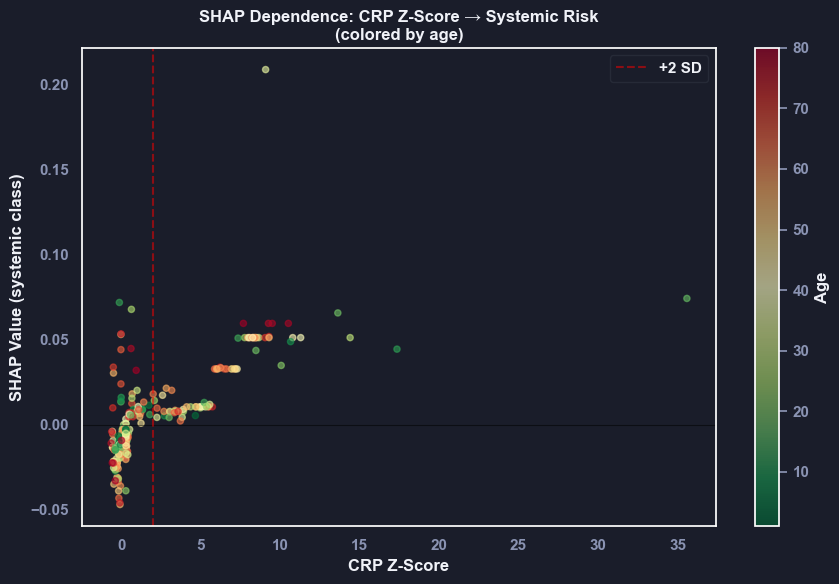

In [12]:
# SHAP dependence: CRP z-score vs its SHAP contribution, colored by age
feat_names = list(X_sample.columns)

crp_zscore_col = 'crp_zscore' if 'crp_zscore' in feat_names else None
age_col = 'age' if 'age' in feat_names else None

if crp_zscore_col and len(shap_values.shape) == 3:
    crp_idx = feat_names.index(crp_zscore_col)
    shap_crp = shap_values.values[:, crp_idx, systemic_idx]
    x_crp = X_sample[crp_zscore_col].values

    fig, ax = plt.subplots(figsize=(9, 6))

    if age_col:
        age_vals = X_sample[age_col].values
        sc = ax.scatter(x_crp, shap_crp, c=age_vals, cmap='RdYlGn_r',
                        alpha=0.6, s=20)
        plt.colorbar(sc, ax=ax, label='Age')
    else:
        ax.scatter(x_crp, shap_crp, alpha=0.4, s=20)

    ax.axhline(y=0, color='black', linewidth=0.8, alpha=0.5)
    ax.axvline(x=2, color='red', linestyle='--', alpha=0.5, label='+2 SD')
    ax.set_xlabel('CRP Z-Score')
    ax.set_ylabel('SHAP Value (systemic class)')
    ax.set_title('SHAP Dependence: CRP Z-Score → Systemic Risk\n(colored by age)', fontweight='bold')
    ax.legend()
    plt.tight_layout()
    plt.savefig('../outputs/figures/05_shap_dependence_crp.png', dpi=150, bbox_inches='tight')
    plt.show()
else:
    print('CRP z-score dependence plot skipped (feature not in model or wrong shape)')

---

## Key Takeaways

1. **ESR and CRP z-scores are the primary global drivers** — confirms clinical knowledge
2. **Each cluster has distinct top features**: Systemic → antibody markers; GI → CRP + demographics
3. **Individual explanations are actionable**: Physicians see which specific values to investigate
4. **Natural language summaries** make predictions interpretable to non-technical users
5. **SHAP is non-linear aware**: Captures interactions that logistic regression coefficients miss

---

*Next: 06_bias_audit.ipynb — Act 4: The Trust (Part 2)*